# Benchmark — Analyse des vidéos (toutes **REAL** )

Ce notebook :
- charge le `benchmark_results.csv` généré par le script result.py,
- affiche un **tableau lisible**,
- calcule **TP, FN, FP, TN** (toutes les vidéos sont **REAL** dans ce benchmark),
- dérive **accuracy, recall, precision, specificity, F1**,
- exporte un **Excel**, un **CSV nettoyé**, un **rapport HTML** + deux graphiques (distribution des confidences, et processing time vs video duration).

In [14]:
# Paramètre : chemin vers ton CSV
CSV_PATH = "benchmark_results.csv"  # <-- modifie si besoin

# Dossiers de sortie (créés à côté du CSV)
import os
OUT_DIR = os.path.dirname(CSV_PATH) if os.path.dirname(CSV_PATH) else "."
print("CSV_PATH:", CSV_PATH)
print("OUT_DIR:", OUT_DIR)

CSV_PATH: benchmark_results.csv
OUT_DIR: .


In [16]:
import pandas as pd
# Paramètre : extension désirée dans le méta (ex: ".MOV" ou ".MP4")

EXT = ".MOV"

# Construit la liste: VIDEO_1 ... VIDEO_31
rows = []
j = 29
for i in range(1, 28):
    rows.append({"file": f"VIDEO_{i}_HD_SHORT{EXT}", "label": "REAL"})
    j += 1

meta_df = pd.DataFrame(rows, columns=["file","label"])
print(meta_df.head(), "\n...\n", meta_df.tail())

# Sauvegarde
META_CSV_PATH = "global_meta.csv"
meta_df.to_csv(META_CSV_PATH, index=False)


                   file label
0  VIDEO_1_HD_SHORT.MOV  REAL
1  VIDEO_2_HD_SHORT.MOV  REAL
2  VIDEO_3_HD_SHORT.MOV  REAL
3  VIDEO_4_HD_SHORT.MOV  REAL
4  VIDEO_5_HD_SHORT.MOV  REAL 
...
                      file label
22  VIDEO_23_HD_SHORT.MOV  REAL
23  VIDEO_24_HD_SHORT.MOV  REAL
24  VIDEO_25_HD_SHORT.MOV  REAL
25  VIDEO_26_HD_SHORT.MOV  REAL
26  VIDEO_27_HD_SHORT.MOV  REAL


In [6]:
# Install (si besoin) : pandas et matplotlib (décommente si tu exécutes dans un environnement vierge)
%pip install pandas matplotlib
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [19]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    for col in ["index","filename","label","confidence","processing_time_sec","video_duration_sec","file_size_mb"]:
        if col not in df.columns:
            df[col] = np.nan
    return df

def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["label"] = d["label"].astype(str).str.upper().str.strip()
    for col in ["confidence","processing_time_sec","video_duration_sec","file_size_mb"]:
        d[col] = pd.to_numeric(d[col], errors="coerce")

    # Vérité terrain et prédictions binaires
    d["true_label"]   = "REAL"                      # CHANGE EN FONCTION DU DATA SET UTILISÉ 
    d["pred_is_real"] = d["label"].eq("REAL")
    d["pred_is_fake"] = d["label"].eq("FAKE")

    # Libellé prédiction explicite pour lisibilité
    d["pred_label"] = np.where(d["pred_is_fake"], "FAKE",
                         np.where(d["pred_is_real"], "REAL", "UNKNOWN"))

    # Correct/erreur + type d'erreur cohérent avec les defs standard
    d["is_correct"] = d["pred_label"].eq(d["true_label"])
    d["error_type"] = np.where(
        (d["true_label"].eq("REAL")) & (d["pred_label"].eq("FAKE")), "FP (REAL→FAKE)",   # fausse alerte
        np.where(
            (d["true_label"].eq("FAKE")) & (d["pred_label"].eq("REAL")), "FN (FAKE→REAL)",
            ""
        )
    )

    # Tri stable
    if "index" in d.columns:
        d = d.sort_values(by=["index","filename"], kind="stable", na_position='last')
    else:
        d = d.sort_values(by=["filename"], kind="stable")
    d.reset_index(drop=True, inplace=True)
    return d

def compute_metrics(d: pd.DataFrame):
    # Positif = FAKE ; Négatif = REAL
    tp = int(((d["true_label"] == "REAL") & (d["pred_label"] == "REAL")).sum())
    tn = int(((d["true_label"] == "FAKE") & (d["pred_label"] == "FAKE")).sum())
    fp = int(((d["true_label"] == "REAL") & (d["pred_label"] == "FAKE")).sum())
    fn = int(((d["true_label"] == "FAKE") & (d["pred_label"] == "REAL")).sum())

    total = tp + tn + fp + fn

    # Métriques (avec garde contre division par zéro)
    accuracy     = (tp + tn) / total if total > 0 else float("nan")
    recall       = tp / (tp + fn) if (tp + fn) > 0 else float("nan")            # TPR (sensibilité) pour FAKE
    precision    = tp / (tp + fp) if (tp + fp) > 0 else float("nan")            # PPV pour FAKE
    specificity  = tn / (tn + fp) if (tn + fp) > 0 else float("nan")            # TNR pour REAL
    f1 = (2 * precision * recall) / (precision + recall) if (
        not math.isnan(precision) and not math.isnan(recall) and (precision + recall) > 0
    ) else float("nan")

    return {
        "TP ": tp,
        "FP ": fp,
        "TN ": tn,
        "FN ": fn,
        "total_samples": total,
        "accuracy": accuracy,
        "recall_FAKE_sensitivity": recall,
        "precision_FAKE": precision,
        "specificity_REAL": specificity,
        "f1_FAKE": f1,
    }

# ====== Usage ======
df_raw = load_csv(CSV_PATH)
df = clean_df(df_raw)
metrics = compute_metrics(df)

print("=== Metrics (positive class = FAKE, negative class = REAL) ===")
for k, v in metrics.items():
    print(f"{k}: {v}")

# Affichage d'un tableau clair
display(HTML("<h3>Tableau complet</h3>"))
display(df[[
    "index","filename","true_label","pred_label","label",
    "confidence","processing_time_sec","video_duration_sec","file_size_mb",
    "is_correct","error_type"
]])


=== Metrics (positive class = FAKE, negative class = REAL) ===
TP : 21
FP : 7
TN : 0
FN : 0
total_samples: 28
accuracy: 0.75
recall_FAKE_sensitivity: 1.0
precision_FAKE: 0.75
specificity_REAL: 0.0
f1_FAKE: 0.8571428571428571


,index,filename,true_label,pred_label,label,confidence,processing_time_sec,video_duration_sec,file_size_mb,is_correct,error_type
0,1,VIDEO_1_HD_SHORT.mp4,REAL,REAL,REAL,51.72,9.72,17.723122,36.489,True,
1,2,VIDEO_2_HD_SHORT.MOV,REAL,REAL,REAL,56.47,4.51,10.475000,10.035,True,
2,3,VIDEO_3_HD_SHORT.mov,REAL,REAL,REAL,54.50,5.33,9.065000,24.614,True,
3,4,VIDEO_4_HD_SHORT.MOV,REAL,REAL,REAL,52.88,8.06,10.231667,10.722,True,
4,5,VIDEO_5_HD_SHORT.MOV,REAL,REAL,REAL,57.51,8.16,13.865000,14.414,True,
5,6,VIDEO_6_HD_SHORT.MOV,REAL,REAL,REAL,57.74,7.80,10.498333,20.129,True,
6,7,VIDEO_7_HD_SHORT.MOV,REAL,REAL,REAL,53.38,12.72,11.075000,21.350,True,
7,8,VIDEO_8_HD_SHORT.MOV,REAL,FAKE,FAKE,52.84,9.06,10.466667,10.850,False,FP (REAL→FAKE)
8,9,VIDEO_9_HD_SHORT.MOV,REAL,REAL,REAL,54.97,7.21,10.841667,10.368,True,
9,10,VIDEO_10_HD_SHORT.MOV,REAL,REAL,REAL,55.52,7.99,11.010000,10.579,True,


In [20]:
# Sauvegardes : Excel, CSV nettoyé
excel_path = os.path.join(OUT_DIR, "benchmark_table.xlsx")
csv_clean_path = os.path.join(OUT_DIR, "benchmark_table_clean.csv")
df.to_excel(excel_path, index=False)
df.to_csv(csv_clean_path, index=False)
print("Saved:", excel_path)
print("Saved:", csv_clean_path)

Saved: .\benchmark_table.xlsx
Saved: .\benchmark_table_clean.csv


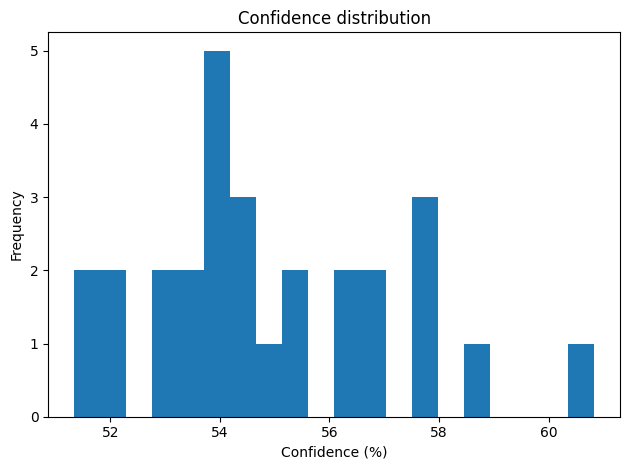

Saved: .\confidence_hist.png


In [21]:
# Graphique 1 : distribution des confidences
plt.figure()
df["confidence"].dropna().plot(kind="hist", bins=20, title="Confidence distribution")
plt.xlabel("Confidence (%)")
plt.tight_layout()
conf_png = os.path.join(OUT_DIR, "confidence_hist.png")
plt.savefig(conf_png, dpi=160)
plt.show()
print("Saved:", conf_png)

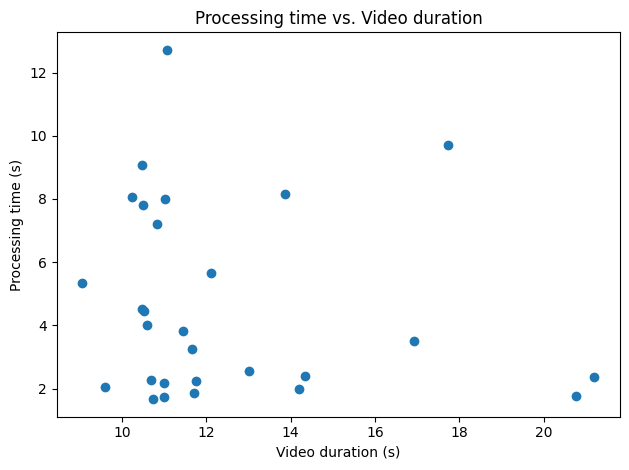

Saved: .\proc_vs_duration.png


In [22]:
# Graphique 2 : Processing time vs Video duration (scatter)
plt.figure()
dd = df.dropna(subset=["processing_time_sec","video_duration_sec"])
plt.scatter(dd["video_duration_sec"], dd["processing_time_sec"])
plt.title("Processing time vs. Video duration")
plt.xlabel("Video duration (s)")
plt.ylabel("Processing time (s)")
plt.tight_layout()
scatter_png = os.path.join(OUT_DIR, "proc_vs_duration.png")
plt.savefig(scatter_png, dpi=160)
plt.show()
print("Saved:", scatter_png)

In [23]:
# Rapport HTML synthétique
from io import StringIO
table_html = df.to_html(index=False)
def fmt(x):
    return f"{x:.4f}" if isinstance(x, float) else str(x)
rows = "".join([f"<tr><td>{k}</td><td>{fmt(v)}</td></tr>" for k,v in metrics.items()])
html = f"""
<!DOCTYPE html>
<html lang='fr'>
<head>
  <meta charset='utf-8'>
  <title>Benchmark Report</title>
  <style>
    body {{ font-family: Arial, sans-serif; margin: 24px; }}
    table {{ border-collapse: collapse; width: 100%; }}
    th, td {{ border: 1px solid #ddd; padding: 8px; }}
    th {{ background: #f5f5f5; text-align: left; }}
    h1, h2, h3 {{ margin-top: 24px; }}
  </style>
</head>
<body>
  <h1>Benchmark Results</h1>
  <h2>Summary metrics (ground truth: FAKE)</h2>
  <table>{rows}</table>
  <h2>Detailed table</h2>
  {table_html}
  <h3>Confidence distribution</h3>
  <img src='confidence_hist.png' style='max-width:800px;'>
  <h3>Processing time vs. Video duration</h3>
  <img src='proc_vs_duration.png' style='max-width:800px;'>
</body>
</html>
"""
html_path = os.path.join(OUT_DIR, "benchmark_report.html")
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html)
print("Saved:", html_path)

Saved: .\benchmark_report.html
